In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from numpy.fft import rfft, rfftfreq

plt.rcParams["figure.figsize"] = (9, 4)


PATH_ART = Path(r"C:\Users\louis\OneDrive\Documents\CWA-DATA.csv")
PATH_DANSE = Path(r"C:\Users\louis\OneDrive\Documents\DanseGlace-.csv")

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)


In [6]:
def load_artistic(path, subject="Sujet1"):
   
    df = pd.read_csv(path, header=None, names=["timestamp", "ax", "ay", "az"])
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["ax"] = df["ax"].astype(float)
    df["ay"] = df["ay"].astype(float)
    df["az"] = df["az"].astype(float)

    # Time in sec
    t0 = df["timestamp"].iloc[0]
    df["time_s"] = (df["timestamp"] - t0).dt.total_seconds()

    # Acceleration
    df["acc_g"] = np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2)

    df["subject"] = subject
    df["discipline"] = "Artistique"
    return df


def load_danse(path, subject="Sujet1"):
   
    df_raw = pd.read_csv(path, header=None, names=["raw"])
    # Split in 4 columns
    splitted = df_raw["raw"].astype(str).str.split(",", n=3, expand=True)
    splitted.columns = ["timestamp", "ax", "ay", "az"]
    df = splitted.copy()

    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S.%f")
    df["ax"] = df["ax"].astype(float)
    df["ay"] = df["ay"].astype(float)
    df["az"] = df["az"].astype(float)

    # Time (sec)
    t0 = df["timestamp"].iloc[0]
    df["time_s"] = (df["timestamp"] - t0).dt.total_seconds()

    # Acceleration
    df["acc_g"] = np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2)

    df["subject"] = subject
    df["discipline"] = "Danse"
    return df


In [7]:
df_art = load_artistic(PATH_ART, subject="Sujet1")
df_danse = load_danse(PATH_DANSE, subject="Sujet1")

print("Patinage artistique :")
print(df_art.head(), "\n")

print("Danse sur glace :")
print(df_danse.head())
# Define the timeframes
start = pd.to_datetime("2025-11-26 19:15:00")
end   = pd.to_datetime("2025-11-26 19:35:00")

# apply the filter
df_danse = df_danse[(df_danse["timestamp"] >= start) &
                    (df_danse["timestamp"] <= end)].copy()

print("Danse 19h15–19h35 :", df_danse.shape)
print(df_danse.head())



Patinage artistique :
                timestamp        ax        ay        az  time_s     acc_g  \
0 2025-10-15 19:20:05.779  1.578125 -0.671875 -1.390625   0.000  2.208106   
1 2025-10-15 19:20:05.789  0.031250  0.906250  0.046875   0.010  0.907999   
2 2025-10-15 19:20:05.800  0.046875  0.984375  0.000000   0.021  0.985490   
3 2025-10-15 19:20:05.809  0.093750  1.031250 -0.046875   0.030  1.036563   
4 2025-10-15 19:20:05.819  0.171875  1.062500 -0.046875   0.040  1.077332   

  subject  discipline  
0  Sujet1  Artistique  
1  Sujet1  Artistique  
2  Sujet1  Artistique  
3  Sujet1  Artistique  
4  Sujet1  Artistique   

Danse sur glace :
                timestamp        ax        ay        az  time_s     acc_g  \
0 2025-11-26 19:15:02.730  0.968750  0.593750  0.109375    0.00  1.141481   
1 2025-11-26 19:15:02.740 -0.062500  0.968750  0.031250    0.01  0.971267   
2 2025-11-26 19:15:02.750 -0.046875  1.015625  0.046875    0.02  1.017786   
3 2025-11-26 19:15:02.760 -0.062500  1.0156

In [8]:
def compute_summary(df, thresholds=(2.0, 3.0, 5.0)):
    # dt above
    dts = df["timestamp"].diff().dt.total_seconds().dropna()
    dt_mean = dts.mean()
    duration_min = df["time_s"].iloc[-1] / 60

    summary = {
        "discipline": df["discipline"].iloc[0],
        "duration_min": duration_min,
        "mean_g": df["acc_g"].mean(),
        "std_g": df["acc_g"].std(),
        "max_g": df["acc_g"].max(),
    }

    for thr in thresholds:
        n = (df["acc_g"] > thr).sum()
        t = n * dt_mean
        summary[f"time_above_{thr}g_min"] = t / 60
        summary[f"n_points_above_{thr}g"] = int(n)

    return summary


In [9]:
summary_art = compute_summary(df_art)
summary_danse = compute_summary(df_danse)

summary_df = pd.DataFrame([summary_art, summary_danse])
summary_df


,discipline,duration_min,mean_g,std_g,max_g,time_above_2.0g_min,n_points_above_2.0g,time_above_3.0g_min,n_points_above_3.0g,time_above_5.0g_min,n_points_above_5.0g
0,Artistique,59.920017,1.247595,1.026176,13.847391,3.245596,20156,2.003619,12443,1.112513,6909
1,Danse,19.954400,1.084625,0.344959,11.748306,0.398871,2468,0.071920,445,0.018586,115


In [10]:
def plot_all_for_discipline(df, name_prefix):
    """
    Crée les graphes pour une discipline (artistique ou danse).
    name_prefix : 'artistique' ou 'danse'
    """
    # dt moyen pour FFT
    dts = df["timestamp"].diff().dt.total_seconds().dropna()
    dt_mean = dts.mean()
    fs = 1.0 / dt_mean

    # --- 1. Série temporelle ---
    plt.figure()
    plt.plot(df["time_s"], df["acc_g"])
    plt.xlabel("Temps (s)")
    plt.ylabel("Accélération totale (g)")
    plt.title(f"Accélération totale – {df['discipline'].iloc[0]}")
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"{name_prefix}_timeseries.png", dpi=300)
    plt.show()

    # --- 2. Histogramme ---
    plt.figure()
    plt.hist(df["acc_g"], bins=80, density=True)
    plt.xlabel("Accélération totale (g)")
    plt.ylabel("Densité")
    plt.title(f"Distribution des accélérations – {df['discipline'].iloc[0]}")
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"{name_prefix}_hist.png", dpi=300)
    plt.show()

    # --- 3. Pics > 3 g ---
    threshold = 3.0
    peaks, _ = find_peaks(df["acc_g"], height=threshold)

    plt.figure()
    plt.plot(df["time_s"], df["acc_g"], label="acc_g")
    if len(peaks) > 0:
        plt.scatter(df["time_s"].iloc[peaks],
                    df["acc_g"].iloc[peaks],
                    s=8,
                    label=f"Pics > {threshold} g")
    plt.axhline(threshold, linestyle="--", label=f"Seuil {threshold} g")
    plt.xlabel("Temps (s)")
    plt.ylabel("Accélération (g)")
    plt.title(f"Pics d'accélération – {df['discipline'].iloc[0]}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"{name_prefix}_peaks_{threshold}g.png", dpi=300)
    plt.show()

    # --- 4. FFT ---
    signal = df["acc_g"] - df["acc_g"].mean()
    N = len(signal)
    freqs = rfftfreq(N, d=dt_mean)
    fft_vals = np.abs(rfft(signal))

    plt.figure()
    plt.plot(freqs, fft_vals)
    plt.xlim(0, 5)
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Amplitude")
    plt.title(f"Spectre fréquentiel – {df['discipline'].iloc[0]}")
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"{name_prefix}_fft.png", dpi=300)
    plt.show()


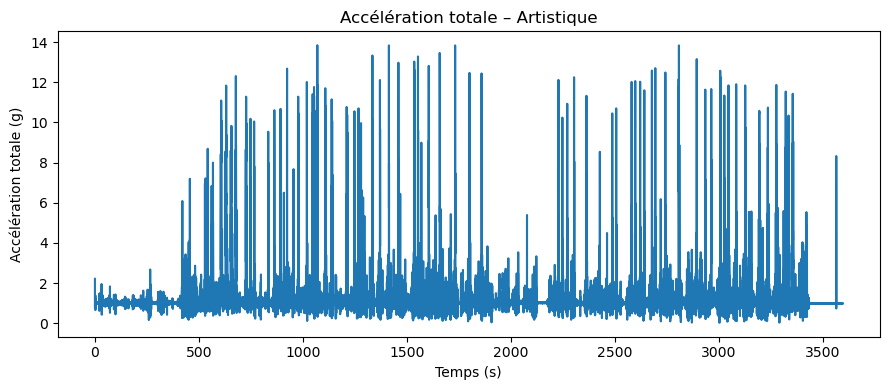

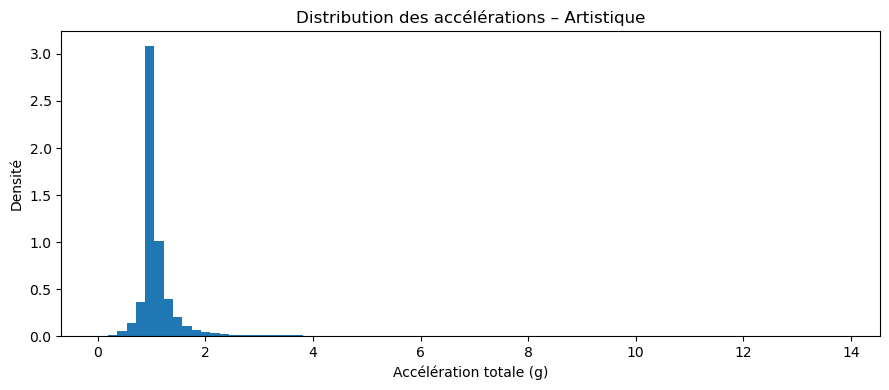

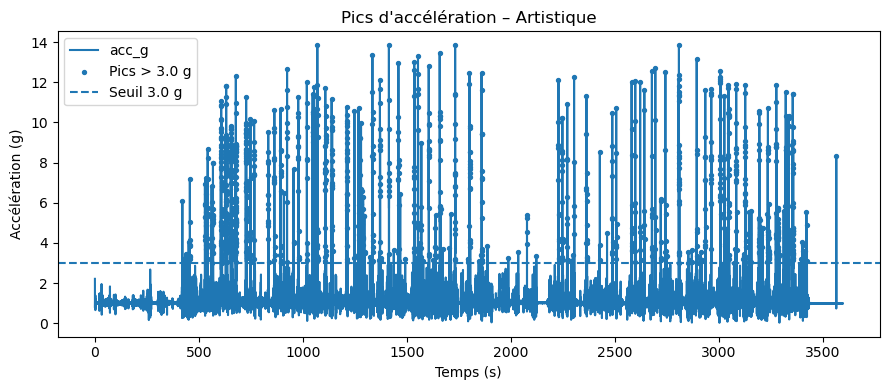

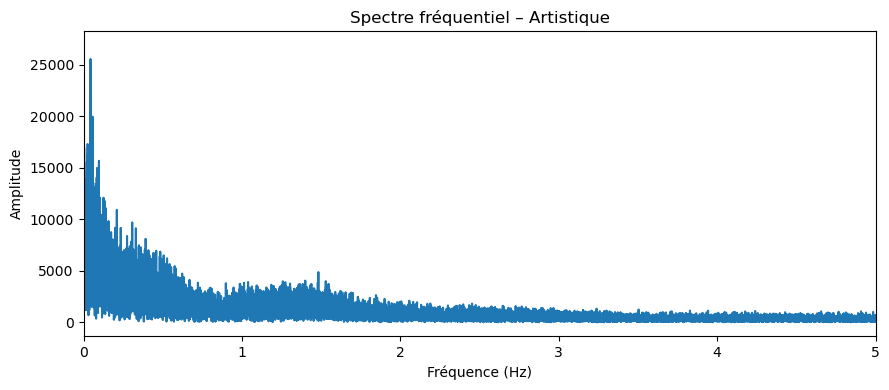

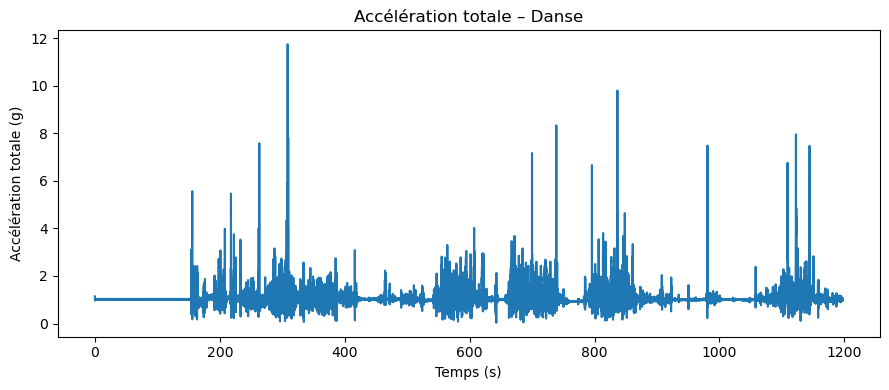

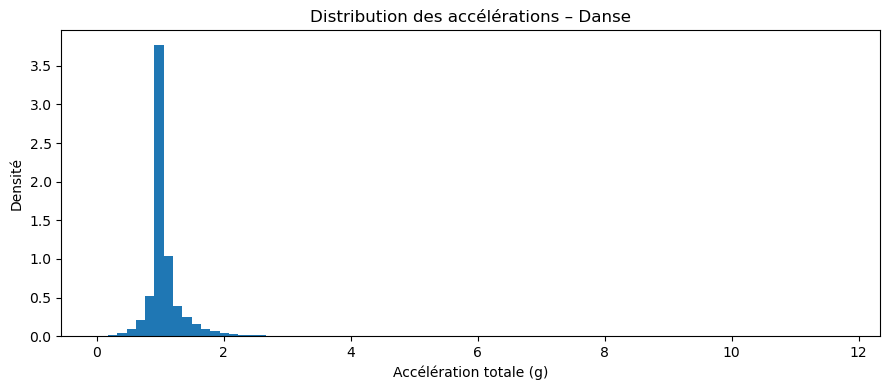

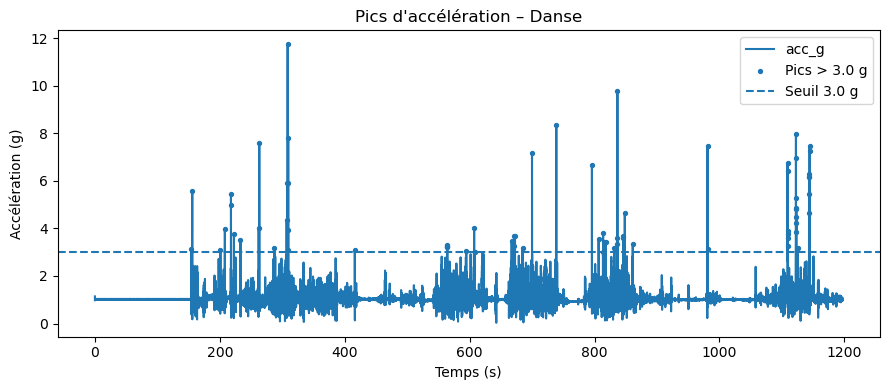

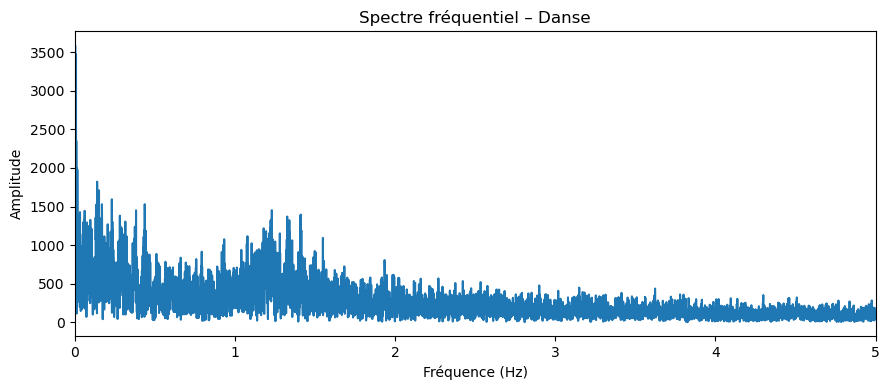

In [11]:
plot_all_for_discipline(df_art, "artistique")
plot_all_for_discipline(df_danse, "danse")


In [12]:
thr = 3.0
n_art = (df_art["acc_g"] > thr).sum()
n_danse = (df_danse["acc_g"] > thr).sum()

print(f"Nombre de points > {thr} g :")
print(f"  Artistique : {n_art}")
print(f"  Danse      : {n_danse}")


Nombre de points > 3.0 g :
  Artistique : 12443
  Danse      : 445


In [13]:
summary_df[[
    "discipline",
    "duration_min",
    "mean_g",
    "std_g",
    "max_g",
    "time_above_2.0g_min",
    "time_above_3.0g_min",
    "time_above_5.0g_min",
    "n_points_above_3.0g",
    "n_points_above_5.0g",
]]


,discipline,duration_min,mean_g,std_g,max_g,time_above_2.0g_min,time_above_3.0g_min,time_above_5.0g_min,n_points_above_3.0g,n_points_above_5.0g
0,Artistique,59.920017,1.247595,1.026176,13.847391,3.245596,2.003619,1.112513,12443,6909
1,Danse,19.954400,1.084625,0.344959,11.748306,0.398871,0.071920,0.018586,445,115


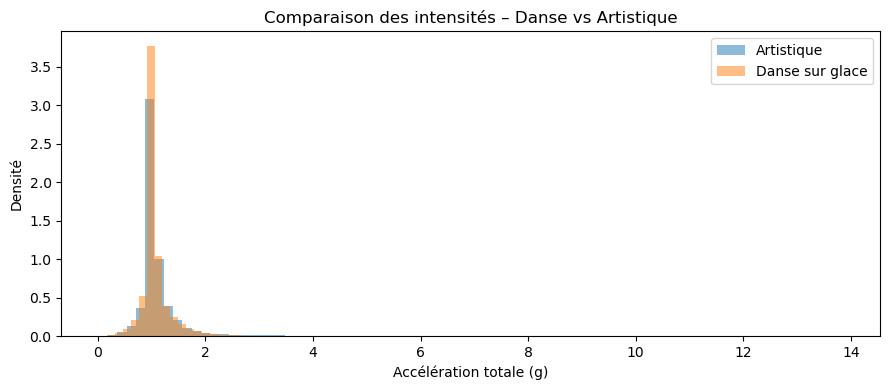

In [14]:


      
plt.figure()
plt.hist(df_art["acc_g"], bins=80, density=True, alpha=0.5, label="Artistique")
plt.hist(df_danse["acc_g"], bins=80, density=True, alpha=0.5, label="Danse sur glace")
plt.xlabel("Accélération totale (g)")
plt.ylabel("Densité")
plt.title("Comparaison des intensités – Danse vs Artistique")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / "compare_hist.png", dpi=300)
plt.show()
    
    